# Import the libraries

In [1]:
import torch
from torch import nn 
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from oscar import Oscar
from model import Transformer
import numpy as np
from matplotlib import pyplot as plt
import random as rd
from torch.optim import Adam

# 1. Training a model
## Initialize the dataset, the model, the optimizer and the loss function

In [2]:
# Initialize Oscar object
oscar = Oscar(language="fr", split="train", max_length=200)

# Define Roberta model
dictionary = list(oscar.get_vocab().keys())

# initialize the transformer model
model = Transformer(dictionary,max_seq_len=200)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

# Take a subset of the dataset to train faster if needed
indices = list(range(0, len(oscar), 10)) 

# Create the subset
subset = torch.utils.data.Subset(oscar, indices)

# Define DataLoader for Oscar dataset
batch_size = 128 # Change this to whatever fits in our GPU
dataloader = DataLoader(oscar, batch_size=batch_size, shuffle=True, num_workers=6)

/home/marceau/.local/lib/python3.10/site-packages/datasets/load.py:2088: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(


File Tokenization/oscar_text.txt found.


## Train loop

Epoch 1/3: 100%|██████████| 1556/1556 [24:58<00:00,  1.04it/s]


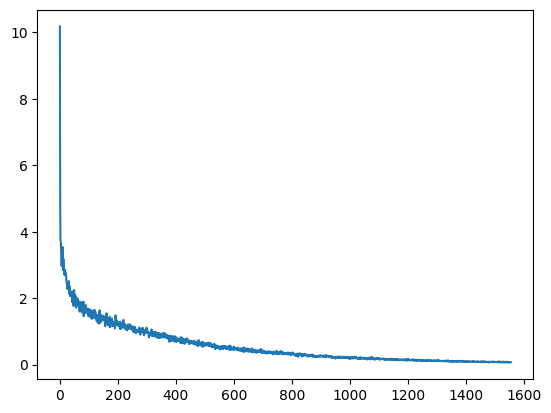

Epoch 1/3, Average Loss: 0.564544920711407


Epoch 2/3: 100%|██████████| 1556/1556 [25:00<00:00,  1.04it/s]


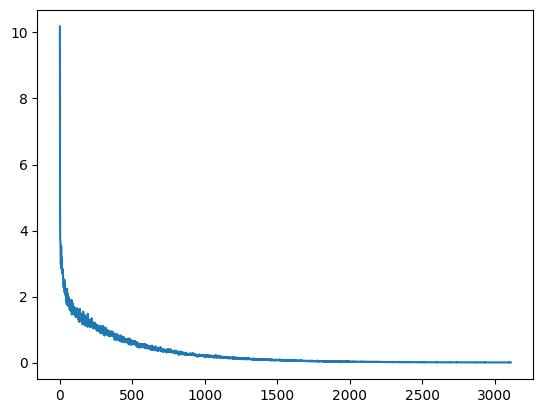

Epoch 2/3, Average Loss: 0.02177759112355091


Epoch 3/3: 100%|██████████| 1556/1556 [24:59<00:00,  1.04it/s]


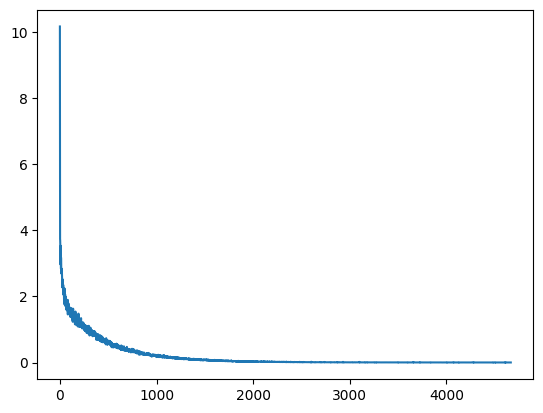

Epoch 3/3, Average Loss: 0.002228821885989318


In [3]:
# Define the optimizer and the scheduler
optimizer = Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
num_epochs = 3 # Change this too if we want to train for more epochs
best_loss = float('inf') # Set initial loss to infinity
patience, trials = 10, 0 # Early stopping

losses = [] # Keep track of losses
total_losses = [] # Keep track of total losses

model.train()  # Ensure the model is in training mode
for epoch in range(num_epochs):
    total_loss = 0
    optimizer.zero_grad()  # Reset gradients at the beginning of each epoch
    for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
        # Move inputs/targets to the GPU/CPU
        inputs, targets = inputs.to(device), targets.to(device)

        # Create attention mask
        attn_mask = torch.full([model.max_seq_len, len(inputs)], -np.inf)
        attn_mask = torch.triu(attn_mask, diagonal=1).to(device)

        # Forward pass
        outputs = model(inputs, targets, attn_mask)

        # Calculate loss
        loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
        loss.backward()  # Backward pass

        # Perform optimization step
        optimizer.step()
        optimizer.zero_grad()

        # Keep track of losses
        total_loss += loss.item()
        losses.append(loss.item())

    # Keep track of total losses
    total_losses.append(total_loss)
    scheduler.step()

    # Save the loss plot to the 'loss' directory
    plt.figure()
    plt.plot(losses)
    plt.show()
    
    # Print average loss for the epoch
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss}")

    # Early stopping
    if avg_loss < best_loss:
        trials = 0
        best_loss = avg_loss
        torch.save(model.state_dict(), "train_camembert.pth")
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break


   


## Check the loss of the model on the training set

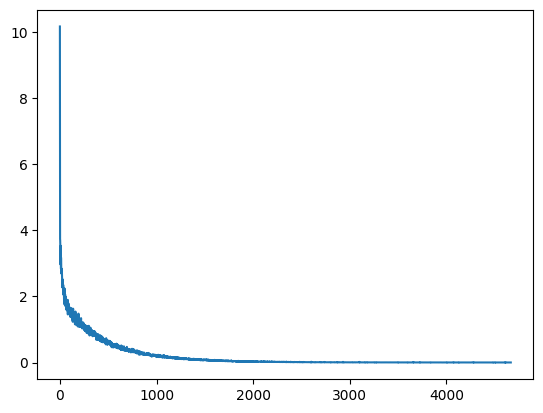

0.0008443492115475237


In [4]:
# Plot the losses and print the last loss
plt.figure()
plt.plot(losses)
plt.show()
print(losses[-1])

# 2. Load a pretrained model

In [5]:
# Load the weights from the .pth file
weights= torch.load('train_camembert.pth')

In [6]:
#model = Transformer(dictionary, num_layers=6) #for camembert et camembert2
model = Transformer(dictionary, num_layers=6, d_model=768, num_heads=12) #for camembert3 and camembert4_lr10-3
# Apply these weights to the model
model.load_state_dict(weights)

<All keys matched successfully>

# Evaluate the model

In [7]:
model.eval()

# Set device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Predict function that takes a sentence and returns the predicted sentence
def predict(sentence):
    # output is the <s> token (start of sentence)
    output = torch.Tensor([1])
    for i in range(6, model.max_seq_len):
        # convert the sentence to a tensor and put the tensors on the GPU/CPU
        sentence = torch.Tensor(sentence)
        sentence, output = sentence.long(), output.long()
        sentence, output = sentence.to(device), output.to(device)

        # Predict the next token
        predicted = model(sentence, output, None)
        
        # Get the prediction of the i-th token
        predicted = predicted[i]
        # Get the index of the predicted token (the token with the highest probability)
        output = torch.argmax(predicted)
        # find the index of the <mask> token in the sentence and replace it with the predicted token
        idx = (sentence == 4).nonzero(as_tuple=True)[0][0]
        if idx == model.max_seq_len-1 : 
            # if the <mask> token is at the maximum length of the sentence stop predicting
            sentence[idx] = 2
            break
        sentence[idx] = output
        # Add a <mask> token at the end of the sentence to predict the next token
        sentence[idx+1] = 4
    return sentence

sentence = "je vais acheter du <mask>"
a = predict(oscar.tokenize_text(sentence))
print(oscar.ids_to_tokens(a.tolist()))


['<s>', '▁je', '▁vais', '▁acheter', '▁du', '▁', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pa